In [14]:
import os
import sys
sys.path.append("/mnt/scratch/henrypurcell/N3AS/Emu_scripts/spinflip")
import yt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py
from constants import c, M_p, M_3flavor, G, hbar
import spin_flip_tools as sft
import gellmann as gm
import four_current as fc
import matrix
import constants
import diagonalizer as dg
import time_plots as tp
import merger_grid as mg
import glob
import concurrent
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator,LogLocator)
from matplotlib import cm, colors
import matplotlib.axes as ax
from mpl_toolkits.mplot3d import Axes3D
from four_current import four_current, read_gradients
from matrix import visualizer
import argparse
#import latex
from itertools import product

# For ease of development, reload the relevant modules to make sure they are up to date.
import importlib
importlib.reload(constants)
importlib.reload(sft)
importlib.reload(gm)
importlib.reload(fc)
importlib.reload(matrix)
importlib.reload(dg)
importlib.reload(tp)
importlib.reload(mg)

################
# plot options #
################
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rc('text', usetex=True)

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True

mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['axes.grid'] = False

np.set_printoptions(precision=16)

#####################
###plot parameters###
#####################


#location to save png's
plot_output_file = "/mnt/scratch/henrypurcell/N3AS/5-figures/"

#resolutions
resolution = 300

merger_data_filename = "/mnt/scratch/shared/2-orthonormal_distributions/model_rl0_orthonormal_rotated.h5"
emu_data_loc = "/mnt/scratch/shared/3-Henry_NSM_box/"
gradient_filename = "/mnt/scratch/shared/4-gradients/gradients_start.h5"

#3 z-values of cross sections to plot
zvals = [97,98,99]

#location of specific point to analyze
location=[80,73,zvals[2]] #will appear in middle plot in contour_plot hence zvals[1]
emu_filename = emu_data_loc + "i{:03d}".format(location[0])+"_j{:03d}".format(location[1])+"_k{:03d}".format(location[2])+"/allData.h5"

#boundaries of regions over which gradients have been computed (for adiabaticity analysis)
#nth item in list corresponds to nth cross section (currently all are the same)
xmins = [75,75,75]
xmaxs = [83,83,83]
ymins = [67,67,67]
ymaxs = [77,77,77]

#neutrino momentum
p_abs = 1e7 # eV



In [15]:
######################################
### PART 2: 3-FLAVOR, 3D SPIN-FLIP ###
######################################

#compute relevant SpinParams object for the given point
SP_0 = sft.SpinParams(0,
                      emu_filename,
                      merger_data_filename,
                      location,
                      p_abs,
                      resonance_type = 'simplified',
                      gradient_filename = gradient_filename)


In [18]:
### Angular plot of Eigenvector Resonance value (1-|L-R|) and zoomed in version of the same ###
SP_0.angularEigenvectorPlot(300, 300,
                             value = 'lminusr',
                             phi_optimal = 3/4*np.pi,
                             zoom = 0.08,
                             shift = [-0.04,0],
                             vmax = -4.5, vmin = -9,
                             zoom_resolution = 300,
                             initvector = 'default', 
                             method = 'Nelder-Mead',
                             bounds =[(np.pi/4, 3*np.pi/4)], 
                             savefig= plot_output_file + 'angular_eigenvector_plot_init',
                             linearPlot = False)



theta_optimal =  1.389623608365678  along phi =  2.356194490192345  with max_right =  0.998243383472372


array(['1.3905985799211569', '1.308282306683681', '1.363324843723427'],
      dtype='<U32')

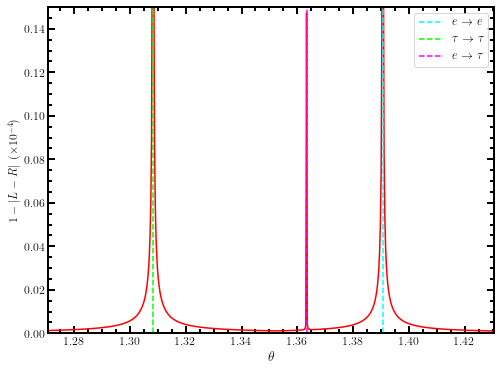

In [70]:
### Linear plot of Eigenvector resonance value vs theta for phi = 3/4 pi (shows 1D phi-slice of zoomed in picture from previous plot)###
# this identifies resonance bands in the channels given in flavor-resonances with the given colors. There are 9 resonance bands total, and we can show 3
# after showing 3 resonance bands we can plot their evolution in the next plot to show they are resonant.
SP_0.linearEigenvectorPlot( 2*resolution,  
                            initvector = None, value = 'lminusr',
                            zoom = 0.08, shift = -0.04, phi_optimal= np.pi,
                            method = 'Nelder-Mead',
                            vmax = 0.15,
                            extra_lines = None, extra_init_vectors = None,
                            flavor_resonances = [(0,0,'cyan'), (2,2,'lime'), (0,2,'magenta')],
                            savefig = plot_output_file + 'linear_eigenvector_plot_init')


In [31]:
### Compute resonant thetas on resonance bands for the next plot, and find the resonant angular width according to generalized resonance condition ###
find_res_regions = SP_0.findResonantRegions(theta_resolution = 1000, 
                                            phi_optimal = np.pi,
                                            min_dist_between_peaks = 20,
                                            limits = [1.3, 1.4],
                                            resonance_threshold = 1 + 1/6 - np.sqrt(1 - (1/6)**2),
                                            max_peak_count = 3,
                                            method = 'Nelder-Mead',
                                            makeplot = False,
                                            printvalues = True)
# print total resonant width that will be used in description of the plot
resonant_width = find_res_regions['total_width']
print('total initial resonant width = ', resonant_width)



max_thetas =  [1.3082823027521582 1.3633276237176344 1.390598583145226 ]
computed Omega (only registered if greater than 0.18065336948339739) =  [4.242640182527531, 4.242628856882547, 4.242640198154022]


KeyboardInterrupt: 

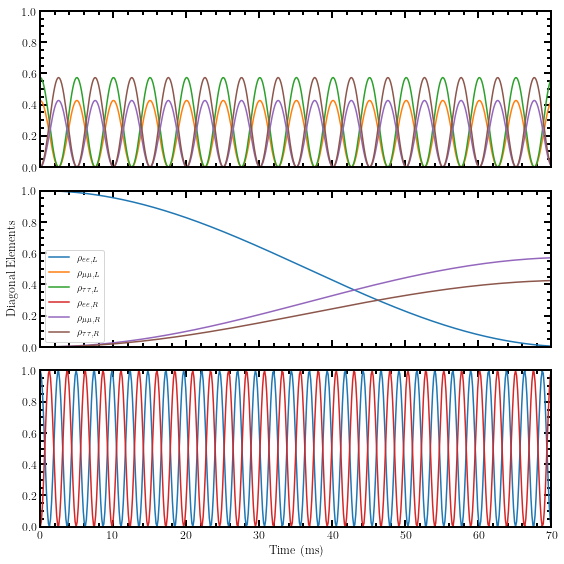

In [13]:
### Diagnonalizer plot for identified resonance bands: shows evolution of resonant state for the resonant hamiltonians identified in the last plot
# first compute the resonant thetas, vectors and Hamiltonians corresponding to these thetas
resonant_thetas = find_res_regions['resonant_thetas']
resonant_states = SP_0.resonant_states(resonant_thetas, P = True)
resonant_Hs = np.array([SP_0.H(float(theta),np.pi) for theta in resonant_thetas])
#make plot
dg.multi_H_Plotter( resonant_Hs,
                    t_lim_array = 0.07,
                    quantity_array = np.array([0,1,2,3,4,5]),
                    resolution = 500,
                    ylim = None,
                    init_state_array = resonant_states,
                    savefig = plot_output_file + 'mutli_H_plotter_init')


total initial adiabatic width =  2.670665910642356e-10


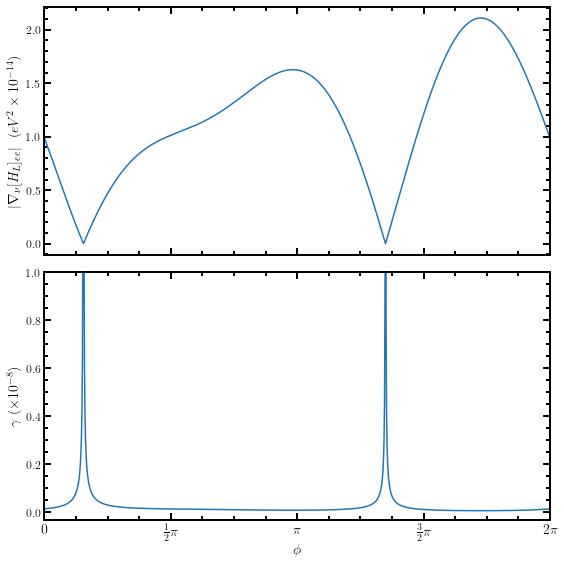

In [58]:
### Single-Point Adiabaticity plot: shows adiabaticity and gradient vs azimuthal angle over resonance band for selected point ###
SP_0.azimuthalGradientsPlot(phi_resolution = 1000,  
                            vmax = 1,
                            savefig = plot_output_file + 'azimuthal_gradients_init')



### Adiabaticity width for single-point: prints and returns the angular width of the adiabatic region on the resonance band at the given point
# We'll quote this value when describing the plot
adiabatic_width = SP_0.findAdiabaticRegions(phi_resolution = resolution,
                          min_dist_between_peaks = 10,
                          adiabaticity_threshold = 1,
                          max_peak_count = 3, 
                          method = 'Nelder-Mead')

print('total initial adiabatic width = ', adiabatic_width)



In [14]:
###############################
### PART 3: FFI SIMULATION  ###
###############################

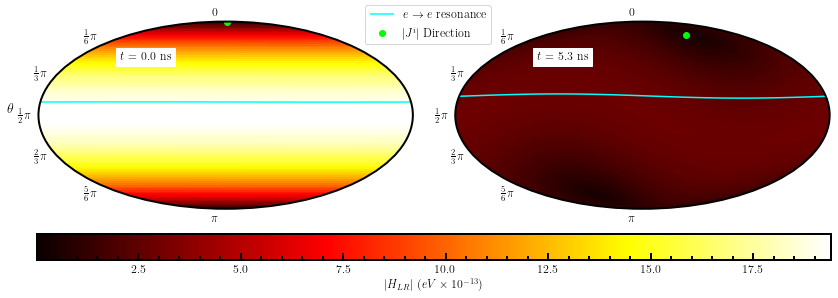

In [29]:
### Angular Plot of H_LR, before and after simulation ###
sft.multi_HLR_Plotter( 
                    0, 200,
                    emu_filename,
                    merger_data_filename,
                    location,
                    p_abs,
                    resolution,
                    resolution, 
                    resonance_type = 'simplified',
                    savefig= plot_output_file + 'angular_hlr_init',
                    use_gm=True,
                    direction_point=False)


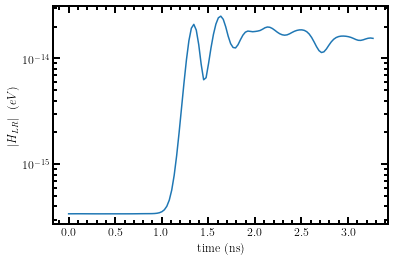

In [16]:
### time plot of H_LR increasing during instability in z direction ###
TP = tp.TimePlots([0,125], emu_filename,  merger_data_filename, location, p_abs)
TP.plot( quantity = 'H_LR', 
        avg_method = 'GM', 
        theta=0, phi=0, 
        savefig = plot_output_file + 'hlr_time_evolution')

In [ ]:
###########################################
###### PART 3: FULL MERGER ANALYSIS #######
###########################################

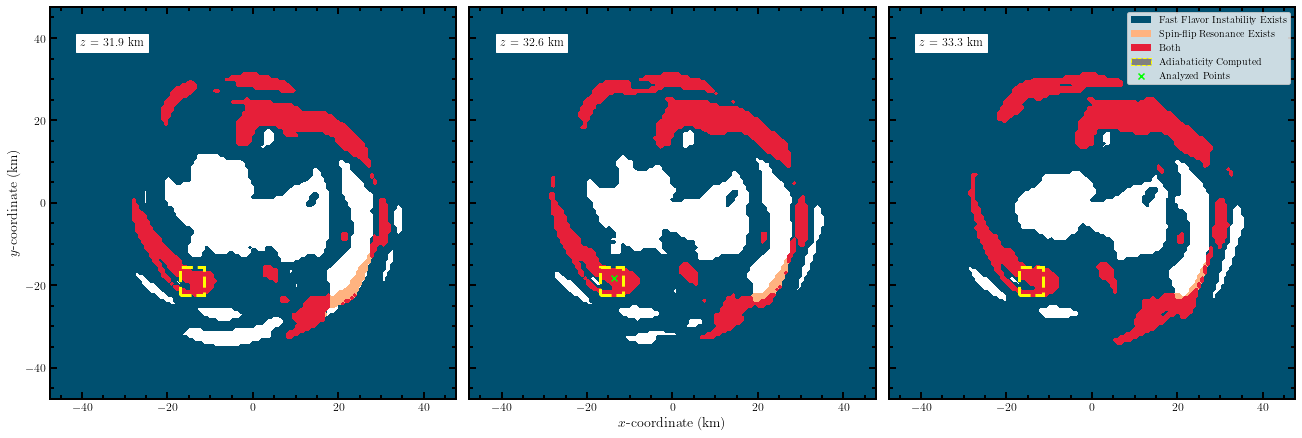

In [ ]:
### Resonance and FFI Regions Plot: plots resonance and FFI regions on z-cross sections ###
mg.Merger_Grid(zvals,
               merger_data_loc=merger_data_filename,
               p_abs=p_abs
                ).contour_plot(
                            x=[None,location[0],None], 
                            y=[None,location[1],None], 
                            rect_xmin = xmins, rect_xmax = xmaxs,
                            rect_ymin = ymins, rect_ymax = ymaxs,
                            savefig = plot_output_file + 'merger_grid_init')


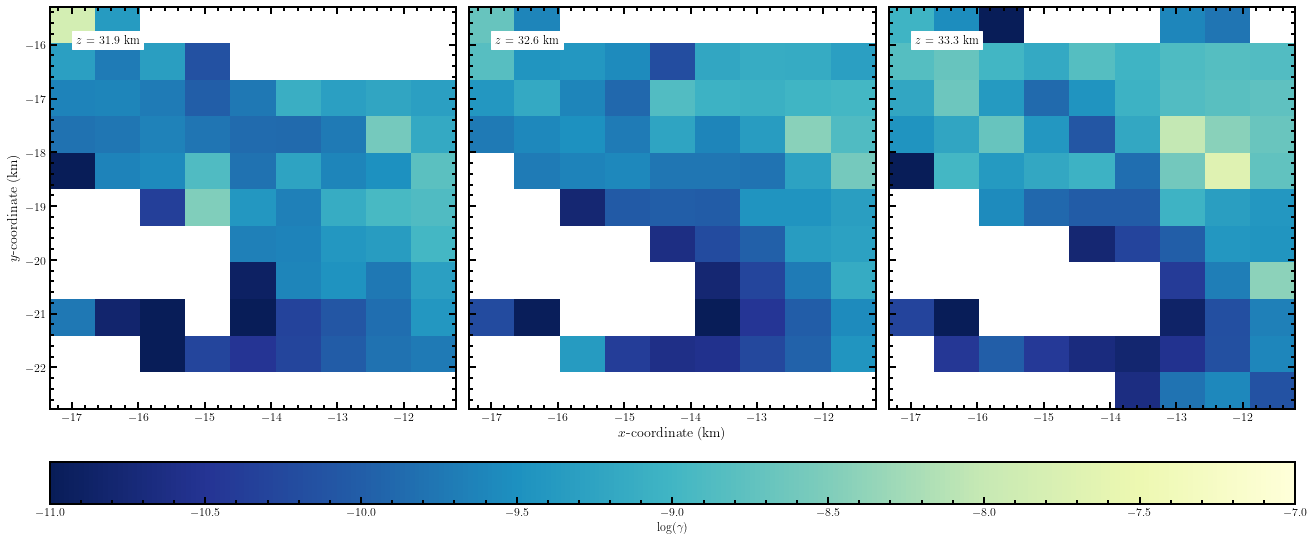

In [ ]:
### Adiabaticity Plot: plots average value of adiabaticity on resonance band at each grid cell###
#(averaging over azimuthal anglues, picking phi_resolution of these at each cell)
#Plots for z-cross sections - first input is a list of z's to plot. We can do 3 cross sections for the paper
sft.Gradients(gradient_filename, 
              merger_data_filename
              ).plotAdiabaticities(zvals,
                                   emu_data_loc, 
                                   p_abs,
                                   1E-11, 1E-7,
                                   savefig = plot_output_file + 'adiabaticity_grid_init')
